In [27]:
include("F_calculations.jl");
using BenchmarkTools

In [4]:
# We can take normchoice to be SNRnorm, SNRnorm_low, or SNRnorm_high
function DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)
    c0 = 3e8 # m s^(-1)
    if bh_frac == "21"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar) 
        + (ηAD(22, 15)+ηAD(27, 25))*Fmass(E*(1+z)/(1+z0), i, "large", ordering, nubar) + (ηAD(25, 22)+ηAD(125, 27))*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    elseif bh_frac == "41"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar) 
        + ηAD(125, 15)*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    elseif bh_frac == "09"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar)
        + ηAD(40, 15)*Fmass(E*(1+z)/(1+z0), i, "large", ordering, nubar) + ηAD(125, 40)*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    else
        return 0
    end
end

# Mass method
DSNB(E, z0, i, nubar, ordering, bh_frac, normchoice) = 1/(1+z0) * quadgk(z -> DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice), z0, 5, rtol=1e-2)[1]

# νe method
function DSNB(E, z0, nubar, ordering, bh_frac, normchoice)
    ν1 = DSNB(E, z0, 1, nubar, ordering, bh_frac, normchoice)
    ν2 = DSNB(E, z0, 2, nubar, ordering, bh_frac, normchoice)
    ν3 = DSNB(E, z0, 3, nubar, ordering, bh_frac, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end


# Separating the progenitors: 1pc ≡ one progenitor contribution

function DSNB_integrand_1pc(E, z0, z, i, nubar, ordering, sm, normchoice)
    c0 = 3e8 # m s^(-1)
    # Adding in this integrated mass function so we can multiply by bh fractions at the end
    return 0.00208 * ηAD(125, 8) * (c0*normchoice*SFR(z)/Hubble(z)) * Fmass(E*(1+z)/(1+z0), i, sm, ordering, nubar)
end

DSNB_1pc(E, z0, i, nubar, ordering, sm, normchoice) = 1/(1+z0) * quadgk(z -> DSNB_integrand_1pc(E, z0, z, i, nubar, ordering, sm, normchoice), z0, 5, rtol=1e-2)[1]

function DSNB_1pc(E, z0, nubar, ordering, sm, normchoice)
    ν1 = DSNB_1pc(E, z0, 1, nubar, ordering, sm, normchoice)
    ν2 = DSNB_1pc(E, z0, 2, nubar, ordering, sm, normchoice)
    ν3 = DSNB_1pc(E, z0, 3, nubar, ordering, sm, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end;

In [37]:
@time DSNB_integrand(1, 0, 0.1, 1, true, "IO", "21", SNRnorm)

  0.000035 seconds (12 allocations: 192 bytes)


0.013501347362099852

In [38]:
@btime @fastmath DSNB(1, 0, 1, true, "IO", "21", SNRnorm)

  28.357 μs (730 allocations: 12.05 KiB)


0.7095897823701633

In [7]:
# Define this effective length function
LeffIntegrand(z) = (H0*sqrt(energy_matter*(1+z)^3 + energy_dark))^(-1)*(1+z)^(-2)

leff_quadint(z0) = quadgk(z -> LeffIntegrand(z), 0, z0)[1]

zs_leff = range(0, 5, 1000)
leff_ne = Interpolations.interpolate((vec(zs_leff),), leff_quadint.(zs_leff), Gridded(Linear()))
lefftrue = extrapolate(leff_ne, 0.0)

# Approximating with a 14 degree polynomial

# Procedure for fitting the polynomial
#=
xsvec = range(0, 5, 100)
leffsvec = 70*leff.(xsvec)

p = Polynomials.fit(xsvec, leffsvec, 14)
=#

function leff(x) 
    if x == 0.0
        return 0.0
    else
        (3.844126829887412e-6 + 0.9994711237154343*x - 1.2171757160998375*x^2 + 1.2011732904692138*x^3 - 1.0258795580085436*x^4 + 0.7535135022231549*x^5 - 0.4576091931617817*x^6 + 0.2207326320476638*x^7 - 0.0820545498767346*x^8 + 0.022953521018636694*x^9 - 0.004712524469463747*x^(10) + 0.0006858791896371295*x^(11) - 6.682066367256103e-5*x^(12) + 3.9015397017829775e-6*x^(13) - 1.0310563080271216e-7*x^(14))/70
    end
end

# Decay function 
function decay(E, α, z0, z)
    scalefactor = 4.68e28
    return exp(-scalefactor*α*(leff(z) - leff(z0))*(1+z0)/E)
end

decay (generic function with 1 method)

In [9]:
@time decay(1, 10^(-26), 0.1, 1)

  0.000001 seconds


0.09355412803774756

In [10]:
# This function returns the redshift point where the decay function has attenuated by 
# roughly two orders of magnitude, and if we break the integral bounds at this point the integral might run faster
# with QuadGK.jl
function zcutoff(E, α, z0)
    innerpart = 0.007+(E/(4.68e28*α))*log(0.01*exp(-4.68e28*α*leff(z0)/E))
    if innerpart > 0.0
        return -0.555*(log(350*(innerpart))-0.9)
    else
        return 0.0
    end
end;

In [11]:
# Invisible decay implementation

# Mass method
function DSNB_idecay(E, z0, α, i, nubar, ordering, bh_frac, normchoice)
    zcut = zcutoff(E, α, z0)
    if zcut > z0 && zcut < 5 && decay(E, α, z0, zcut) < 0.1
        return quadgk(z -> 1/(1+z0) * DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)*decay(E, α, z0, z), z0, zcut, 5, rtol=1e-2)[1]
    else
        return quadgk(z -> 1/(1+z0) * DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)*decay(E, α, z0, z), z0, 5, rtol=1e-2)[1]
    end
end

# νe method
function DSNB_idecay(E, z0, α1, α2, α3, nubar, ordering, bh_frac, normchoice)
    ν1 = DSNB_idecay(E, z0, α1, 1, nubar, ordering, bh_frac, normchoice)
    ν2 = DSNB_idecay(E, z0, α2, 2, nubar, ordering, bh_frac, normchoice)
    ν3 = DSNB_idecay(E, z0, α3, 3, nubar, ordering, bh_frac, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end

# Single progenitor versions
function DSNB_idecay_1pc(E, z0, α, i, nubar, ordering, sm, normchoice)
    zcut = zcutoff(E, α, z0)
    if zcut > z0 && zcut < 5 && decay(E, α, z0, zcut) < 0.1
        return quadgk(z -> 1/(1+z0) * DSNB_integrand_1pc(E, z0, z, i, nubar, ordering, sm, normchoice)*decay(E, α, z0, z), z0, zcut, 5, rtol=1e-2)[1]
    else
        return quadgk(z -> 1/(1+z0) * DSNB_integrand_1pc(E, z0, z, i, nubar, ordering, sm, normchoice)*decay(E, α, z0, z), z0, 5, rtol=1e-2)[1]
    end
end

function DSNB_idecay_1pc(E, z0, α1, α2, α3, nubar, ordering, sm, normchoice)
    ν1 = DSNB_idecay_1pc(E, z0, α1, 1, nubar, ordering, sm, normchoice)
    ν2 = DSNB_idecay_1pc(E, z0, α2, 2, nubar, ordering, sm, normchoice)
    ν3 = DSNB_idecay_1pc(E, z0, α3, 3, nubar, ordering, sm, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end;

In [13]:
@time DSNB_idecay_1pc(10, 0, 10^(-24), 10^(-24), 10^(-24), true, "IO", "small", SNRnorm)

  0.000118 seconds (1.07 k allocations: 17.828 KiB)


0.0026975589069186266

In [14]:
# Energy spectrum function for SH case
function ψSH(Eh, El, hc)
    if hc
        return 2*El/Eh^2
    else
        return (2/Eh)*(1-(El/Eh))
    end
end;

In [15]:
# 2ν SH treatment assuming the smallest mass state has a mass of ≈0 (so all channels are SH except for IO ν2 → ν1, which is QD)

# We take m_j > m_i
function qcontrib_2ν(E, z0, z, j, jbar, i, ibar, αj, ordering, bh_frac, normchoice)

    if ordering == "NO" && j <= i
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 1 && i == 2
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 3 && i == 1
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 3 && i == 2
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 2 && i == 1
        if jbar != ibar
            return 0.0
        else
            Ers = E*(1+z)/(1+z0)
            qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
            return qnorm * (c0/Hubble(z))*DSNB_idecay(Ers, z, αj, j, jbar, ordering, bh_frac, normchoice) * (αj/Ers)
        end
    else
        if jbar == ibar
            hc = true
        else
            hc = false
        end

        Ers = E*(1+z)/(1+z0)

        qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
        integrand(Eprime) = qnorm * (c0/Hubble(z))*DSNB_idecay(Eprime, z, αj, j, jbar, ordering, bh_frac, normchoice) * (αj * 0.5/Eprime) * ψSH(Eprime, Ers, hc)
        Emax = Ers + 50

        return quadgk(Eprime -> integrand(Eprime), Ers, Emax, rtol=1e-2)[1]
    end
end

function DSNB_vdecay_2ν(E, αj, i, ibar, ordering, bh_frac, normchoice)
    if αj == 0
        return DSNB_idecay(E, 0, 0, i, ibar, ordering, bh_frac, normchoice)
    elseif ordering == "NO" && i == 3
        return DSNB_idecay(E, 0, αj, i, ibar, "NO", bh_frac, normchoice)
    elseif ordering == "IO" && i == 2
        return DSNB_idecay(E, 0, αj, i, ibar, "IO", bh_frac, normchoice)
    else
        # Here, for NO we take ν2 to be stable and for IO we take ν1 to be stable, and we take the lightest mass states to be stable as well
        if ordering == "NO"
            qint = quadgk(z -> (qcontrib_2ν(E, 0, z, 3, false, i, ibar, αj, "NO", bh_frac, normchoice)+qcontrib_2ν(E, 0, z, 3, true, i, ibar, αj, "NO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        elseif ordering == "IO"
            qint = quadgk(z -> (qcontrib_2ν(E, 0, z, 2, false, i, ibar, αj, "IO", bh_frac, normchoice)+qcontrib_2ν(E, 0, z, 2, true, i, ibar, αj, "IO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        else
            return println("error: ordering takes either 'NO' or 'IO'")
        end
        return DSNB_idecay(E, 0, 0, i, ibar, ordering, bh_frac, normchoice) + qint
    end
end;

# Other few cases where the heaviest mass state and lightest mass state are stable, and the middle mass state decays into the lightest mass state
function DSNB_vdecay_2ν_alt(E, αj, i, ibar, ordering, bh_frac, normchoice)
    if αj == 0
        return DSNB_idecay(E, 0, 0, i, ibar, ordering, bh_frac, normchoice)
    elseif ordering == "NO" && i == 2
        return DSNB_idecay(E, 0, αj, i, ibar, "NO", bh_frac, normchoice)
    elseif ordering == "IO" && i == 1
        return DSNB_idecay(E, 0, αj, i, ibar, "IO", bh_frac, normchoice)
    elseif ordering == "NO" && i == 3
        return DSNB_idecay(E, 0, 0, i, ibar, "NO", bh_frac, normchoice)
    elseif ordering == "IO" && i == 2
        return DSNB_idecay(E, 0, 0, i, ibar, "IO", bh_frac, normchoice)
    else
        # Here, for NO we take ν1 to be stable and for IO we take ν2 to be stable, and we take the lightest mass states to be stable as well
        if ordering == "NO"
            qint = quadgk(z -> (qcontrib_2ν(E, 0, z, 2, false, i, ibar, αj, "NO", bh_frac, normchoice)+qcontrib_2ν(E, 0, z, 2, true, i, ibar, αj, "NO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        elseif ordering == "IO"
            qint = quadgk(z -> (qcontrib_2ν(E, 0, z, 1, false, i, ibar, αj, "IO", bh_frac, normchoice)+qcontrib_2ν(E, 0, z, 1, true, i, ibar, αj, "IO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        else
            return println("error: ordering takes either 'NO' or 'IO'")
        end
        return DSNB_idecay(E, 0, 0, i, ibar, ordering, bh_frac, normchoice) + qint
    end
end

# daughter specifies the state the heaviest mass state decays into in our 2ν framework
function DSNB_vdecay_2ν_νe(E, α, daughter, ebar, ordering, bh_frac, normchoice)
    if ordering == "NO"
        if daughter == 1
            α1, α2, α3 = α, 0.0, α
        elseif daughter == 2
            α1, α2, α3 = 0.0, α, α
        else
            return println("error: for NO, 'daughter' must be either ν1 or ν2")
        end
    elseif ordering == "IO"
        if daughter == 3
            α3, α1, α2 = α, 0.0, α
        elseif daughter == 1
            α3, α1, α2 = 0.0, α, α
        else
            return println("error: for IO, 'daughter' must be either ν1 or ν3")
        end
    else
        return println("error: ordering must take either 'NO' or 'IO'")
    end
    ν3 = DSNB_vdecay_2ν(E, α3, 3, ebar, ordering, bh_frac, normchoice)
    ν2 = DSNB_vdecay_2ν(E, α2, 2, ebar, ordering, bh_frac, normchoice)
    ν1 = DSNB_vdecay_2ν(E, α1, 1, ebar, ordering, bh_frac, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end

# If we don't specify a daughter, the decay channel is assumed to be from the second lightest to the lightest state
function DSNB_vdecay_2ν_νe(E, α, ebar, ordering, bh_frac, normchoice)
    if ordering == "NO"
        α1, α2, α3 = α, α, 0.0
    elseif ordering == "IO"
        α1, α2, α3 = α, 0.0, α
    else
        return println("error: ordering must take either 'NO' or 'IO'")
    end
    ν3 = DSNB_vdecay_2ν_alt(E, α3, 3, ebar, ordering, bh_frac, normchoice)
    ν2 = DSNB_vdecay_2ν_alt(E, α2, 2, ebar, ordering, bh_frac, normchoice)
    ν1 = DSNB_vdecay_2ν_alt(E, α1, 1, ebar, ordering, bh_frac, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end


# Single progenitor versions
function qcontrib_2ν_1pc(E, z0, z, j, jbar, i, ibar, αj, ordering, sm, normchoice)

    if ordering == "NO" && j <= i
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 1 && i == 2
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 3 && i == 1
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 3 && i == 2
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 2 && i == 1
        if jbar != ibar
            return 0.0
        else
            Ers = E*(1+z)/(1+z0)
            qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
            return qnorm * (c0/Hubble(z))*DSNB_idecay_1pc(Ers, z, αj, j, jbar, ordering, sm, normchoice) * (αj/Ers)
        end
    else
        if jbar == ibar
            hc = true
        else
            hc = false
        end

        Ers = E*(1+z)/(1+z0)

        qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
        integrand(Eprime) = qnorm * (c0/Hubble(z))*DSNB_idecay_1pc(Eprime, z, αj, j, jbar, ordering, sm, normchoice) * (αj * 0.5/Eprime) * ψSH(Eprime, Ers, hc)
        Emax = Ers + 50

        return quadgk(Eprime -> integrand(Eprime), Ers, Emax, rtol=1e-2)[1]
    end
end

function DSNB_vdecay_2ν_1pc(E, αj, i, ibar, ordering, sm, normchoice)
    if αj == 0
        return DSNB_idecay_1pc(E, 0, 0, i, ibar, ordering, sm, normchoice)
    elseif ordering == "NO" && i == 3
        return DSNB_idecay_1pc(E, 0, αj, i, ibar, "NO", sm, normchoice)
    elseif ordering == "IO" && i == 2
        return DSNB_idecay_1pc(E, 0, αj, i, ibar, "IO", sm, normchoice)
    else
        # Here, for NO we take ν2 to be stable and for IO we take ν1 to be stable, and we take the lightest mass states to be stable as well
        if ordering == "NO"
            qint = quadgk(z -> (qcontrib_2ν_1pc(E, 0, z, 3, false, i, ibar, αj, "NO", sm, normchoice)+qcontrib_2ν_1pc(E, 0, z, 3, true, i, ibar, αj, "NO", sm, normchoice)), 0, 5, rtol=1e-2)[1]
        elseif ordering == "IO"
            qint = quadgk(z -> (qcontrib_2ν_1pc(E, 0, z, 2, false, i, ibar, αj, "IO", sm, normchoice)+qcontrib_2ν_1pc(E, 0, z, 2, true, i, ibar, αj, "IO", sm, normchoice)), 0, 5, rtol=1e-2)[1]
        else
            return println("error: ordering takes either 'NO' or 'IO'")
        end
        return DSNB_idecay_1pc(E, 0, 0, i, ibar, ordering, sm, normchoice) + qint
    end
end;

# Other few cases where the heaviest mass state and lightest mass state are stable, and the middle mass state decays into the lightest mass state
function DSNB_vdecay_2ν_alt_1pc(E, αj, i, ibar, ordering, sm, normchoice)
    if αj == 0
        return DSNB_idecay_1pc(E, 0, 0, i, ibar, ordering, sm, normchoice)
    elseif ordering == "NO" && i == 2
        return DSNB_idecay_1pc(E, 0, αj, i, ibar, "NO", sm, normchoice)
    elseif ordering == "IO" && i == 1
        return DSNB_idecay_1pc(E, 0, αj, i, ibar, "IO", sm, normchoice)
    elseif ordering == "NO" && i == 3
        return DSNB_idecay_1pc(E, 0, 0, i, ibar, "NO", sm, normchoice)
    elseif ordering == "IO" && i == 2
        return DSNB_idecay_1pc(E, 0, 0, i, ibar, "IO", sm, normchoice)
    else
        # Here, for NO we take ν1 to be stable and for IO we take ν2 to be stable, and we take the lightest mass states to be stable as well
        if ordering == "NO"
            qint = quadgk(z -> (qcontrib_2ν_1pc(E, 0, z, 2, false, i, ibar, αj, "NO", sm, normchoice)+qcontrib_2ν_1pc(E, 0, z, 2, true, i, ibar, αj, "NO", sm, normchoice)), 0, 5, rtol=1e-2)[1]
        elseif ordering == "IO"
            qint = quadgk(z -> (qcontrib_2ν_1pc(E, 0, z, 1, false, i, ibar, αj, "IO", sm, normchoice)+qcontrib_2ν_1pc(E, 0, z, 1, true, i, ibar, αj, "IO", sm, normchoice)), 0, 5, rtol=1e-2)[1]
        else
            return println("error: ordering takes either 'NO' or 'IO'")
        end
        return DSNB_idecay_1pc(E, 0, 0, i, ibar, ordering, sm, normchoice) + qint
    end
end

# daughter specifies the state the heaviest mass state decays into in our 2ν framework
function DSNB_vdecay_2ν_νe_1pc(E, α, daughter, ebar, ordering, sm, normchoice)
    if ordering == "NO"
        if daughter == 1
            α1, α2, α3 = α, 0.0, α
        elseif daughter == 2
            α1, α2, α3 = 0.0, α, α
        else
            return println("error: for NO, 'daughter' must be either ν1 or ν2")
        end
    elseif ordering == "IO"
        if daughter == 3
            α3, α1, α2 = α, 0.0, α
        elseif daughter == 1
            α3, α1, α2 = 0.0, α, α
        else
            return println("error: for IO, 'daughter' must be either ν1 or ν3")
        end
    else
        return println("error: ordering must take either 'NO' or 'IO'")
    end
    ν3 = DSNB_vdecay_2ν_1pc(E, α3, 3, ebar, ordering, sm, normchoice)
    ν2 = DSNB_vdecay_2ν_1pc(E, α2, 2, ebar, ordering, sm, normchoice)
    ν1 = DSNB_vdecay_2ν_1pc(E, α1, 1, ebar, ordering, sm, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end

# If we don't specify a daughter, the decay channel is assumed to be from the second lightest to the lightest state
function DSNB_vdecay_2ν_νe_1pc(E, α, ebar, ordering, sm, normchoice)
    if ordering == "NO"
        α1, α2, α3 = α, α, 0.0
    elseif ordering == "IO"
        α1, α2, α3 = α, 0.0, α
    else
        return println("error: ordering must take either 'NO' or 'IO'")
    end
    ν3 = DSNB_vdecay_2ν_alt_1pc(E, α3, 3, ebar, ordering, sm, normchoice)
    ν2 = DSNB_vdecay_2ν_alt_1pc(E, α2, 2, ebar, ordering, sm, normchoice)
    ν1 = DSNB_vdecay_2ν_alt_1pc(E, α1, 1, ebar, ordering, sm, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end;

In [18]:
@time DSNB_vdecay_2ν_νe_1pc(10, 10^(-26), true, "NO", "small", SNRnorm)

  0.028561 seconds (169.32 k allocations: 2.763 MiB)


0.4817981208265538

In [19]:
# 3ν NO SH treatment

function branch_3ν_NO(j, i)
    if j == 3
        return 0.25
    elseif j == 2
        return 0.5
    else
        return println("error: j is not a valid index")
    end
end

#=
function DSNB_vdecay_3_NO(E, z0, α3, threebar, bh_frac, normchoice)
    function decay_integrand(E, z0, z, α3, threebar, bh_frac, normchoice)
        if α3 == 0
            return DSNB_integrand(E, z0, z, 3, threebar, "NO", bh_frac, normchoice)
        else
            int = DSNB_integrand(E, z0, z, 3, threebar, "NO", bh_frac, normchoice)*decay(E, α3, z0, z) 
            if isnan(int) || isinf(int)
                return 0.0
            else
                return int
            end
        end
    end
    return 1/(1+z0) * quadgk(z -> decay_integrand(E, z0, z, α3, threebar, bh_frac, normchoice), z0, 5, rtol=1e-2)[1]
end
=#

function q3icontrib_NO(E, z0, z, α3, threebar, i, ibar, bh_frac, normchoice)
    if threebar == ibar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_idecay(Eprime, z, α3, 3, threebar, "NO", bh_frac, normchoice) * (α3 * branch_3ν_NO(3, i)/Eprime) * ψSH(Eprime, Ers, hc)
    
    Emax = Ers + 50

    return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]

end

function DSNB_vdecay_2_NO(E, z0, α3, α2, twobar, bh_frac, normchoice)
    integrand(z) = (DSNB_integrand(E, z0, z, 2, twobar, "NO", bh_frac, normchoice) +
                          q3icontrib_NO(E, z0, z, α3, true, 2, twobar, bh_frac, normchoice) + q3icontrib_NO(E, z0, z, α3, false, 2, twobar, bh_frac, normchoice))*decay(E, α2, z0, z)
    zcut = zcutoff(E, α2, z0)
    if zcut > z0 && zcut < 5 && decay(E, α2, z0, zcut) < 0.1
        return (1/(1+z0)) * quadgk(z -> integrand(z), z0, zcut, 5, rtol=1e-2)[1]
    else
        return (1/(1+z0)) * quadgk(z -> integrand(z), z0, 5, rtol=1e-2)[1]
    end
end

# Old and slower implementation
#=
function q21contrib_NO(E, z0, z, α3, α2, twobar, onebar, bh_frac, normchoice)
    if twobar == onebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_vdecay_2_NO(Eprime, z, α3, α2, twobar, bh_frac, normchoice) * (α2 * branch_3ν_NO(2, 1)/Eprime) * ψSH(Eprime, Ers, hc)
    
    Emax = Ers + 50

    return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]

end
=#

function q21contrib_NO(E, z0, z, α3, α2, twobar, onebar, bh_frac, normchoice)
    if twobar == onebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_vdecay_2_NO(Eprime, z, α3, α2, twobar, bh_frac, normchoice) * (α2 * branch_3ν_NO(2, 1)/Eprime) * ψSH(Eprime, Ers, hc)
    
    Emax = Ers + 50

    Ecutoff = 1.5*100^(1/3)*Ers
    if Ecutoff < Emax && (ψSH(Ecutoff, Ers, hc)/Ecutoff)/(ψSH(Ers, Ers, hc)/Ers) < 0.1
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Ecutoff, Emax, rtol=1e-2)[1]
    else
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]
    end
end

# z0 is always 0 here because we're only concerned with the flux at Earth
function DSNB_vdecay_1_NO(E, α3, α2, onebar, bh_frac, normchoice)
    integrand(z) = (DSNB_integrand(E, 0, z, 1, onebar, "NO", bh_frac, normchoice)
                    + q21contrib_NO(E, 0, z, α3, α2, true, onebar, bh_frac, normchoice)
                    + q21contrib_NO(E, 0, z, α3, α2, false, onebar, bh_frac, normchoice)
                    + q3icontrib_NO(E, 0, z, α3, true, 1, onebar, bh_frac, normchoice)
                    + q3icontrib_NO(E, 0, z, α3, false, 1, onebar, bh_frac, normchoice))
    return quadgk(z -> integrand(z), 0, 5, rtol=1e-2)[1]
end

function DSNB_vdecay_3ν_νe_NO(E, α3, α2, nubar, bh_frac, normchoice)
    ν3 = DSNB_idecay(E, 0, α3, 3, nubar, "NO", bh_frac, normchoice)
    ν2 = DSNB_vdecay_2_NO(E, 0, α3, α2, nubar, bh_frac, normchoice)
    ν1 = DSNB_vdecay_1_NO(E, α3, α2, nubar, bh_frac, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end;  

In [26]:
@time q21contrib_NO(10, 0, 0, 10^(-25), 10^(-25), true, true, "21", SNRnorm)

  1.251210 seconds (14.35 M allocations: 225.513 MiB, 7.05% gc time)


0.1971904354140483

In [22]:
@time DSNB_vdecay_3ν_νe_NO(10, 0, 0, true, "21", SNRnorm)

111.439053 seconds (1.49 G allocations: 22.971 GiB, 10.52% gc time)


0.5866483555543647

In [20]:
# 3ν IO treatment (2 → 1 QD, 2/1 → 3 SH)

# Case A
# ν2 → ν1, ν2 → ν3, no ν1 → ν3:
# B_21 = 0.5 (no hf), B_23 = 0.25, B_13 = 0
# NB: here if we want to only consider visible decays, we should set α1 to 0 always

# Case B
# ν2 → ν1, ν1 → ν3, no ν2 → ν3:
# B_21 = 1 (no hf), B_13 = 0.5, B_23 = 0

# Case C
# ν2 → ν3, ν1 → ν3, no ν2 → ν1
# B_23 = 0.5, B_13 = 0.5, B_21 = 0

# Democratic
# ν2 → ν3, ν1 → ν3, ν2 → ν1
# B_21 = B_23 = 1/3, B_13 = 0.5

# Note: supposing validity of SH and QD approximations, branching ratios are set in B and C

function branching_3ν_IO(casechoice, j, jbar, i, ibar)
    if casechoice == "A"
        if j == 2 && i == 1 && jbar == ibar
            return 0.5
        elseif j == 2 && i == 3
            return 0.25
        else
            return 0.0
        end
    elseif casechoice == "B"
        if j == 2 && i == 1 && jbar == ibar
            return 1.0
        elseif j == 1 && i == 3
            return 0.5
        else 
            return 0.0
        end
    elseif casechoice == "C"
        if j == 2 && i == 3
            return 0.5
        elseif j == 1 && i == 3
            return 0.5
        else
            return 0.0
        end
    elseif casechoice == "democratic"
        if (j == 2 && i == 1 && jbar == ibar) || (j == 2 && i == 3)
            return 1/3
        elseif j == 1 && i == 3
            return 0.5
        else
            return 0.0
        end
    else
        return 0.0
    end
end

#=
function DSNB_vdecay_2_IO(E, z0, α2, twobar, bh_frac, normchoice)
    function decay_integrand(E, z0, z, α2, twobar, bh_frac, normchoice)
        if α2 == 0
            return DSNB_integrand(E, z0, z, 2, twobar, "IO", bh_frac, normchoice)
        else
            int = DSNB_integrand(E, z0, z, 2, twobar, "IO", bh_frac, normchoice)*decay(E, α2, z0, z) 
            if isnan(int) || isinf(int)
                return 0.0
            else
                return int
            end
        end
    end
    return 1/(1+z0) * quadgk(z -> decay_integrand(E, z0, z, α2, twobar, bh_frac, normchoice), z0, 5, rtol=1e-2)[1]
end
=#

function q21contrib_IO(E, z0, z, α2, nubar, casechoice, bh_frac, normchoice)

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    return qnorm * (c0/Hubble(z)) *  DSNB_idecay(Ers, z, α2, 2, nubar, "IO", bh_frac, normchoice) * (α2 * branching_3ν_IO(casechoice, 2, nubar, 1, nubar)/Ers)
end

function DSNB_vdecay_1_IO(E, z0, α2, α1, nubar, casechoice, bh_frac, normchoice)
    if casechoice == "A"
        α1 = 0
    end
    integrand(z) = (DSNB_integrand(E, z0, z, 1, nubar, "IO", bh_frac, normchoice) +
                        q21contrib_IO(E, z0, z, α2, nubar, casechoice, bh_frac, normchoice))*decay(E, α1, z0, z)
    zcut = zcutoff(E, α1, z0)
    if zcut > z0 && zcut < 5 && decay(E, α1, z0, zcut) < 0.1
        return (1/(1+z0)) * quadgk(z -> integrand(z), z0, zcut, 5, rtol=1e-2)[1]
    else
        return (1/(1+z0)) * quadgk(z -> integrand(z), z0, 5, rtol=1e-2)[1]
    end
end

function q23contrib_IO(E, z0, z, α2, twobar, threebar, casechoice, bh_frac, normchoice)

    if twobar == threebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_idecay(Eprime, z, α2, 2, twobar, "IO", bh_frac, normchoice) * (α2 * branching_3ν_IO(casechoice, 2, twobar, 3, threebar)/Eprime) * ψSH(Eprime, Ers, hc)

    Emax = Ers + 50

    Ecutoff = 1.5*100^(1/3)*Ers
    if Ecutoff < Emax && (ψSH(Ecutoff, Ers, hc)/Ecutoff)/(ψSH(Ers, Ers, hc)/Ers) < 0.1
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Ecutoff, Emax, rtol=1e-2)[1]
    else
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]
    end
end

function q13contrib_IO(E, z0, z, α2, α1, onebar, threebar, casechoice, bh_frac, normchoice)

    if onebar == threebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_vdecay_1_IO(Eprime, z, α2, α1, onebar, casechoice, bh_frac, normchoice) * (α1 * branching_3ν_IO(casechoice, 1, onebar, 3, threebar)/Eprime) * ψSH(Eprime, Ers, hc)

    Emax = Ers + 50

    Ecutoff = 1.5*100^(1/3)*Ers
    if Ecutoff < Emax && (ψSH(Ecutoff, Ers, hc)/Ecutoff)/(ψSH(Ers, Ers, hc)/Ers) < 0.1
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Ecutoff, Emax, rtol=1e-2)[1]
    else
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]
    end
end

function q13contrib_IO_test(E, z0, z, α2, α1, onebar, threebar, casechoice, bh_frac, normchoice)

    if onebar == threebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime) = qnorm * (c0/Hubble(z))*DSNB_vdecay_1_IO(Eprime, z, α2, α1, onebar, casechoice, bh_frac, normchoice) * (α1 * branching_3ν_IO(casechoice, 1, onebar, 3, threebar)/Eprime) * ψSH(Eprime, Ers, hc)

    Emax = Ers + 50
    #=
    if Emax > 100
        return quadgk(Eprime -> integrand(Eprime), Ers, 100, Inf, rtol=1e-2)[1]
    else
        return quadgk(Eprime -> integrand(Eprime), Ers, Emax, rtol=1e-2)[1]
    end
    =#
    return quadgk(u -> integrand(u*(1+z))*(1+z), E/(1+z0), (E/(1+z0))+50, rtol=1e-2)[1]
end

function DSNB_vdecay_3_IO(E, α2, α1, threebar, casechoice, bh_frac, normchoice)
    integrand(z) = (DSNB_integrand(E, 0, z, 3, threebar, "IO", bh_frac, normchoice)
                    + q23contrib_IO(E, 0, z, α2, true, threebar, casechoice, bh_frac, normchoice)
                    + q23contrib_IO(E, 0, z, α2, false, threebar, casechoice, bh_frac, normchoice)
                    + q13contrib_IO(E, 0, z, α2, α1, true, threebar, casechoice, bh_frac, normchoice)
                    + q13contrib_IO(E, 0, z, α2, α1, false, threebar, casechoice, bh_frac, normchoice))
    return quadgk(z -> integrand(z), 0, 5, rtol=1e-2)[1]
end

function DSNB_vdecay_3ν_νe_IO(E, α2, α1, nubar, casechoice, bh_frac, normchoice)

    ν3 = DSNB_vdecay_3_IO(E, α2, α1, nubar, casechoice, bh_frac, normchoice)
    ν2 = DSNB_idecay(E, 0, α2, 2, nubar, "IO", bh_frac, normchoice)
    ν1 = DSNB_vdecay_1_IO(E, 0, α2, α1, nubar, casechoice, bh_frac, normchoice)
    
    return Usqred("IO")[1, 1]*ν1 + Usqred("IO")[1, 2]*ν2 + Usqred("IO")[1, 3]*ν3
end

#######################################

# Per progenitor:

function q21contrib_IO_1pc(E, z0, z, α2, nubar, casechoice, sm, normchoice)

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    return qnorm * (c0/Hubble(z)) *  DSNB_idecay_1pc(Ers, z, α2, 2, nubar, "IO", sm, normchoice) * (α2 * branching_3ν_IO(casechoice, 2, nubar, 1, nubar)/Ers)
end

function DSNB_vdecay_1_IO_1pc(E, z0, α2, α1, nubar, casechoice, sm, normchoice)
    if casechoice == "A"
        α1 = 0
    end
    integrand(z) = (DSNB_integrand_1pc(E, z0, z, 1, nubar, "IO", sm, normchoice) +
                        q21contrib_IO_1pc(E, z0, z, α2, nubar, casechoice, sm, normchoice))*decay(E, α1, z0, z)
    zcut = zcutoff(E, α1, z0)
    if zcut > z0 && zcut < 5 && decay(E, α1, z0, zcut) < 0.1
        return (1/(1+z0)) * quadgk(z -> integrand(z), z0, zcut, 5, rtol=1e-2)[1]
    else
        return (1/(1+z0)) * quadgk(z -> integrand(z), z0, 5, rtol=1e-2)[1]
    end
end

function q23contrib_IO_1pc(E, z0, z, α2, twobar, threebar, casechoice, sm, normchoice)

    if twobar == threebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_idecay_1pc(Eprime, z, α2, 2, twobar, "IO", sm, normchoice) * (α2 * branching_3ν_IO(casechoice, 2, twobar, 3, threebar)/Eprime) * ψSH(Eprime, Ers, hc)

    Emax = Ers + 50

    Ecutoff = 1.5*100^(1/3)*Ers
    if Ecutoff < Emax && (ψSH(Ecutoff, Ers, hc)/Ecutoff)/(ψSH(Ers, Ers, hc)/Ers) < 0.1
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Ecutoff, Emax, rtol=1e-2)[1]
    else
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]
    end
end

function q13contrib_IO_1pc(E, z0, z, α2, α1, onebar, threebar, casechoice, sm, normchoice)

    if onebar == threebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_vdecay_1_IO_1pc(Eprime, z, α2, α1, onebar, casechoice, sm, normchoice) * (α1 * branching_3ν_IO(casechoice, 1, onebar, 3, threebar)/Eprime) * ψSH(Eprime, Ers, hc)

    Emax = Ers + 50

    Ecutoff = 1.5*100^(1/3)*Ers
    if Ecutoff < Emax && (ψSH(Ecutoff, Ers, hc)/Ecutoff)/(ψSH(Ers, Ers, hc)/Ers) < 0.1
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Ecutoff, Emax, rtol=1e-2)[1]
    else
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]
    end
end

#=
function q13contrib_IO_test(E, z0, z, α2, α1, onebar, threebar, casechoice, bh_frac, normchoice)

    if onebar == threebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime) = qnorm * (c0/Hubble(z))*DSNB_vdecay_1_IO(Eprime, z, α2, α1, onebar, casechoice, bh_frac, normchoice) * (α1 * branching_3ν_IO(casechoice, 1, onebar, 3, threebar)/Eprime) * ψSH(Eprime, Ers, hc)

    Emax = Ers + 50
    #=
    if Emax > 100
        return quadgk(Eprime -> integrand(Eprime), Ers, 100, Inf, rtol=1e-2)[1]
    else
        return quadgk(Eprime -> integrand(Eprime), Ers, Emax, rtol=1e-2)[1]
    end
    =#
    return quadgk(u -> integrand(u*(1+z))*(1+z), E/(1+z0), (E/(1+z0))+50, rtol=1e-2)[1]
end
=#

function DSNB_vdecay_3_IO_1pc(E, α2, α1, threebar, casechoice, sm, normchoice)
    integrand(z) = (DSNB_integrand_1pc(E, 0, z, 3, threebar, "IO", sm, normchoice)
                    + q23contrib_IO_1pc(E, 0, z, α2, true, threebar, casechoice, sm, normchoice)
                    + q23contrib_IO_1pc(E, 0, z, α2, false, threebar, casechoice, sm, normchoice)
                    + q13contrib_IO_1pc(E, 0, z, α2, α1, true, threebar, casechoice, sm, normchoice)
                    + q13contrib_IO_1pc(E, 0, z, α2, α1, false, threebar, casechoice, sm, normchoice))
    return quadgk(z -> integrand(z), 0, 5, rtol=1e-2)[1]
end

function DSNB_vdecay_3ν_νe_IO_1pc(E, α2, α1, nubar, casechoice, sm, normchoice)

    ν3 = DSNB_vdecay_3_IO_1pc(E, α2, α1, nubar, casechoice, sm, normchoice)
    ν2 = DSNB_idecay_1pc(E, 0, α2, 2, nubar, "IO", sm, normchoice)
    ν1 = DSNB_vdecay_1_IO_1pc(E, 0, α2, α1, nubar, casechoice, sm, normchoice)
    
    return Usqred("IO")[1, 1]*ν1 + Usqred("IO")[1, 2]*ν2 + Usqred("IO")[1, 3]*ν3
end;

In [23]:
es_dsnb = range(0.5, 40, 100);

In [47]:
(13*13*3)

507

In [50]:
@time DSNB_vdecay_3ν_νe_IO_1pc(1, 10^(-24), 10^(-24), false, "democratic", "small", SNRnorm) 

  1.153572 seconds (14.54 M allocations: 236.680 MiB, 6.78% gc time)


0.17661294323361465

In [138]:
dsnb_IO_D_24_24_270sm = DSNB_vdecay_3ν_νe_IO_1pc.(es_dsnb, 10^(-24), 10^(-24), false, "democratic", "large", SNRnorm);

In [139]:
dsnb_IO_D_24_24_bh = DSNB_vdecay_3ν_νe_IO_1pc.(es_dsnb, 10^(-24), 10^(-24), false, "democratic", "bh", SNRnorm);

In [141]:
# (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar) 
# + (ηAD(22, 15)+ηAD(27, 25))*Fmass(E*(1+z)/(1+z0), i, "large", ordering, nubar) + (ηAD(25, 22)+ηAD(125, 27))*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))

((ηAD(15, 8)*dsnb_IO_D_24_24_112sm .+ (ηAD(22, 15)+ηAD(27, 25))*dsnb_IO_D_24_24_270sm .+ (ηAD(25, 22)+ηAD(125, 27))*dsnb_IO_D_24_24_bh) ./ ηAD(125, 8)) .- dsnb_IO_D_24_24

100-element Vector{Float64}:
 -1.9960941233243545e-10
  1.8958509206967733e-9
  1.6839600824880563e-9
 -4.379308859991937e-10
  3.2880561051662482e-9
 -4.841940182132021e-10
 -9.259956135210246e-10
 -4.798868247224419e-10
  2.646495939062632e-10
  1.538346394713841e-10
 -4.13943088140023e-10
  2.4703070838905106e-9
 -3.080095900553914e-10
  ⋮
  2.2910171264441115e-11
  3.8651315221321925e-12
  1.8479989131840735e-11
 -1.8590747040761468e-10
 -5.085867409724068e-11
 -1.3948578023951358e-10
 -2.210641032208971e-10
 -1.2145328492918495e-10
 -1.6521643384989626e-10
  3.039863420662911e-10
 -3.69184603677894e-12
  6.503974778453853e-11

In [53]:
dsnb_IO_nodecay_f21 = DSNB.(es_dsnb, 0, true, "IO", "21", SNRnorm);

In [151]:
dsnb_IO_idecay = DSNB_idecay.(es_dsnb, 0, 10^(-23), 10^(-23), 0, true, "IO", "21", SNRnorm);

dsnb_IO_iidecay = DSNB_idecay.(es_dsnb, 0, 10^(-22), 10^(-22), 0, true, "IO", "21", SNRnorm);

dsnb_IO_iiidecay = DSNB_idecay.(es_dsnb, 0, 10^(-21), 10^(-21), 0, true, "IO", "21", SNRnorm);

In [128]:
dsnb_IO_D_24_24 = DSNB_vdecay_3ν_νe_IO.(es_dsnb, 10^(-24), 10^(-24), false, "democratic", "21", SNRnorm);

In [130]:
dsnb_IO_D_24_24_bar = DSNB_vdecay_3ν_νe_IO.(es_dsnb, 10^(-24), 10^(-24), true, "democratic", "21", SNRnorm);

In [132]:
@time dsnb_IO_B_24_24_bar = DSNB_vdecay_3ν_νe_IO.(es_dsnb, 10^(-24), 10^(-24), true, "B", "21", SNRnorm)

294.917899 seconds (3.42 G allocations: 52.528 GiB, 5.89% gc time)


100-element Vector{Float64}:
 0.18644934643454444
 0.17725151734786423
 0.16746280666696736
 0.157085221697662
 0.14631524289027453
 0.1354360711024642
 0.12472568300381817
 0.11440718416993163
 0.10463541704142838
 0.09550300933668544
 0.08705346559477398
 0.07929489671414772
 0.07221159241932128
 ⋮
 0.0007910317268733975
 0.0007492119743155278
 0.0007096024746176171
 0.000672091511459509
 0.00063657323116868
 0.0006029447851094963
 0.000571113521866223
 0.0005409831697467944
 0.0005124669629840424
 0.00048547838139038435
 0.0004599426207769035
 0.0004357801500017789

In [133]:
@time dsnb_IO_C_24_24_bar = DSNB_vdecay_3ν_νe_IO.(es_dsnb, 10^(-24), 10^(-24), true, "C", "21", SNRnorm)

272.101753 seconds (3.71 G allocations: 56.827 GiB, 6.17% gc time)


100-element Vector{Float64}:
 0.186614467276504
 0.17740803472796834
 0.16760335034964755
 0.1572001078535418
 0.14639325950480905
 0.1354651667878384
 0.12469360271736438
 0.11430198653664933
 0.10444593476208057
 0.09521917709109022
 0.08666650922694172
 0.07879752476821439
 0.07159806810507037
 ⋮
 0.0005085070289433625
 0.000481826222671268
 0.0004565725561617388
 0.0004326675816616731
 0.0004100453777881757
 0.0003886289015572139
 0.0003683653334875874
 0.0003491866503106889
 0.0003310373864054647
 0.00031386007126371835
 0.0002976047044342923
 0.0002822214659841881

In [143]:
dsnb_IO_C_235_235_bar = DSNB_vdecay_3ν_νe_IO.(es_dsnb, 10^(-23.5), 10^(-23.5), true, "B", "21", SNRnorm)

100-element Vector{Float64}:
 0.18671709402781675
 0.17751020493124797
 0.1676997594212544
 0.15728359920153528
 0.14645549872798055
 0.1354973241451725
 0.12468676141005583
 0.11424768465134655
 0.10433634682268042
 0.09504741185101069
 0.08642672965384744
 0.07848503605572416
 0.07120931432551546
 ⋮
 0.00031061822136026223
 0.00029395920966234786
 0.0002782311936876002
 0.00026338305859974795
 0.00024936278326687106
 0.00023612279756766123
 0.00022361831180670998
 0.00021180628351717383
 0.00020064514619086914
 0.0001901034568901563
 0.00018014305348471076
 0.00017073054382513479

In [157]:
α_to_τoverm(10^(-22))

6.596306068601583e6

In [163]:
length(24:0.2:26)

11

In [160]:
dsnb_IO_iidecay ./ dsnb_IO_nodecay_f21

100-element Vector{Float64}:
 0.020783092149722893
 0.021397485201513897
 0.02186175288010143
 0.022209877619535027
 0.022469926867384835
 0.02266558300540473
 0.02281497583833802
 0.022931082719251022
 0.023022859700203846
 0.02309635980212847
 0.02315569083620804
 0.0232036842141848
 0.02324235491738941
 ⋮
 0.022380881549179003
 0.02236029831639141
 0.022339490614605086
 0.022318463799369116
 0.02229722733807494
 0.02227579287404849
 0.0222541708630816
 0.02223237379601104
 0.022210415742114582
 0.02218831119276421
 0.02216607565513508
 0.02214372797317004

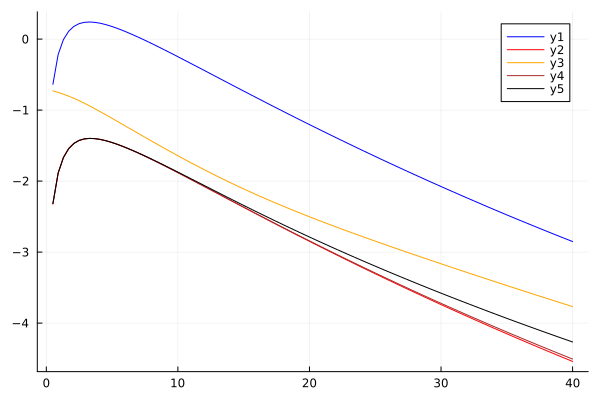

In [152]:
plot(
    es_dsnb,
    [log10.(dsnb_IO_nodecay_f21) log10.(dsnb_IO_iiidecay) log10.(dsnb_IO_C_235_235_bar) log10.(dsnb_IO_iidecay) log10.(dsnb_IO_idecay)],
    c=[:blue :red :orange :brown :black]
)

In [63]:
function branching_3ν_test(casechoice, j, jbar, i, ibar)
    if casechoice == "A"
        if j == 2 && i == 1 && jbar == ibar
            return 0.5
        elseif j == 2 && i == 3
            return 0.25
        else
            return 0.0
        end
    elseif casechoice == "B"
        if j == 2 && i == 1 && jbar == ibar
            return 1.0
        elseif j == 1 && i == 3
            return 0.5
        else 
            return 0.0
        end
    elseif casechoice == "C"
        if j == 2 && i == 3
            return 0.5
        elseif j == 1 && i == 3
            return 0.5
        else
            return 0.0
        end
    elseif casechoice == "democratic"
        if (j == 2 && i == 1 && jbar == ibar) || (j == 2 && i == 3)
            return 1/3
        elseif j == 1 && i == 3
            return 0.5
        else
            return 0.0
        end
    else
        return 0.0
    end
end

function DSNB_vdecay_2_IO_test(E, z0, α2, twobar, bh_frac, normchoice)
    function decay_integrand(E, z0, z, α2, twobar, bh_frac, normchoice)
        if α2 == 0
            return DSNB_integrand(E, z0, z, 2, twobar, "IO", bh_frac, normchoice)
        else
            int = DSNB_integrand(E, z0, z, 2, twobar, "IO", bh_frac, normchoice)*decay(E, α2, z0, z) 
            if isnan(int) || isinf(int)
                return 0.0
            else
                return int
            end
        end
    end
    return 1/(1+z0) * quadgk(z -> decay_integrand(E, z0, z, α2, twobar, bh_frac, normchoice), z0, 5, rtol=1e-2)[1]
end

function q21contrib_IO_test(E, z0, z, α2, nubar, casechoice, bh_frac, normchoice)

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    return qnorm * (c0/Hubble(z)) * DSNB_vdecay_2_IO_test(Ers, z, α2, nubar, bh_frac, normchoice) * (α2 * branching_3ν_test(casechoice, 2, nubar, 1, nubar)/Ers)
end

function DSNB_vdecay_1_IO_test(E, z0, α2, α1, nubar, casechoice, bh_frac, normchoice)
    if casechoice == "A"
        α1 = 0
    end
    integrand(z) = (DSNB_integrand(E, z0, z, 1, nubar, "IO", bh_frac, normchoice) +
                        q21contrib_IO_test(E, z0, z, α2, nubar, casechoice, bh_frac, normchoice))*decay(E, α1, z0, z)
    return (1/(1+z0)) * quadgk(z -> integrand(z), z0, 5, rtol=1e-2)[1]
end

function q23contrib_IO_test(E, z0, z, α2, twobar, threebar, casechoice, bh_frac, normchoice)

    if twobar == threebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_vdecay_2_IO_test(Eprime, z, α2, twobar, bh_frac, normchoice) * (α2 * branching_3ν_test(casechoice, 2, twobar, 3, threebar)/Eprime) * ψSH(Eprime, Ers, hc)

    Emax = Ers + 50
    return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]
end

function q13contrib_IO_test(E, z0, z, α2, α1, onebar, threebar, casechoice, bh_frac, normchoice)

    if onebar == threebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime) = qnorm * (c0/Hubble(z))*DSNB_vdecay_1_IO_test(Eprime, z, α2, α1, onebar, casechoice, bh_frac, normchoice) * (α1 * branching_3ν_test(casechoice, 1, onebar, 3, threebar)/Eprime) * ψSH(Eprime, Ers, hc)

    Emax = Ers + 50
    #=
    if Emax > 100
        return quadgk(Eprime -> integrand(Eprime), Ers, 100, Inf, rtol=1e-2)[1]
    else
        return quadgk(Eprime -> integrand(Eprime), Ers, Emax, rtol=1e-2)[1]
    end
    =#
    return quadgk(Eprime -> integrand(Eprime), Ers, Emax, rtol=1e-2)[1]
end

function DSNB_vdecay_3_IO_test(E, α2, α1, threebar, casechoice, bh_frac, normchoice)
    integrand(z) = (DSNB_integrand(E, 0, z, 3, threebar, "IO", bh_frac, normchoice)
                    + q23contrib_IO_test(E, 0, z, α2, true, threebar, casechoice, bh_frac, normchoice)
                    + q23contrib_IO_test(E, 0, z, α2, false, threebar, casechoice, bh_frac, normchoice)
                    + q13contrib_IO_test(E, 0, z, α2, α1, true, threebar, casechoice, bh_frac, normchoice)
                    + q13contrib_IO_test(E, 0, z, α2, α1, false, threebar, casechoice, bh_frac, normchoice))
    return quadgk(z -> integrand(z), 0, 5, rtol=1e-2)[1]
end

function DSNB_vdecay_3ν_νe_IO_test(E, α2, α1, nubar, casechoice, bh_frac, normchoice)

    ν3 = DSNB_vdecay_3_IO_test(E, α2, α1, nubar, casechoice, bh_frac, normchoice)
    ν2 = DSNB_vdecay_2_IO_test(E, 0, α2, nubar, bh_frac, normchoice)
    ν1 = DSNB_vdecay_1_IO_test(E, 0, α2, α1, nubar, casechoice, bh_frac, normchoice)
    
    return Usqred("IO")[1, 1]*ν1 + Usqred("IO")[1, 2]*ν2 + Usqred("IO")[1, 3]*ν3
end;

In [109]:
function q23contrib_IO_ttest(E, z0, z, α2, twobar, threebar, casechoice, bh_frac, normchoice)

    if twobar == threebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_idecay(Eprime, z, α2, 2, twobar, "IO", bh_frac, normchoice) * (α2 * branching_3ν_IO(casechoice, 2, twobar, 3, threebar)/Eprime) * ψSH(Eprime, Ers, hc)

    Emax = Ers + 50
    #=
    Ecutoff = 1.5*100^(1/3)*Ers
    if Ecutoff < Emax && (ψSH(Ecutoff, Ers, hc)/Ecutoff)/(ψSH(Ers, Ers, hc)/Ers) < 0.1
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Ecutoff, Emax, rtol=1e-2)[1]
    else
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]
    end
    =#
    return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]
end

q23contrib_IO_ttest (generic function with 1 method)

In [113]:
@time q23contrib_IO_ttest(1, 0, 0, 10^(-25), true, true, "democratic", "21", SNRnorm)

  0.003268 seconds (21.86 k allocations: 357.125 KiB)


0.06795983773616145

In [102]:
@time q23contrib_IO_test(1, 0, 0, 10^(-25), true, true, "democratic", "21", SNRnorm)

  0.003291 seconds (27.42 k allocations: 445.641 KiB)


0.06796411578023187

In [120]:
@time DSNB_vdecay_3_IO(1, 10^(-26), 10^(-26), true, "democratic", "21", SNRnorm)

  0.861707 seconds (9.75 M allocations: 154.568 MiB, 6.79% gc time)


4.496545182035049

In [122]:
@time DSNB_vdecay_3_IO_test(1, 10^(-26), 10^(-26), true, "democratic", "21", SNRnorm)

  3.734973 seconds (50.00 M allocations: 785.670 MiB, 6.27% gc time)


4.4965698967209065

In [123]:
@time DSNB_vdecay_3ν_νe_IO(1, 10^(-25), 10^(-25), true, "democratic", "21", SNRnorm)

  2.025173 seconds (8.96 M allocations: 164.078 MiB, 5.73% gc time, 53.77% compilation time)


0.16996901039535156

In [124]:
@time DSNB_vdecay_3ν_νe_IO_test(1, 10^(-25), 10^(-25), true, "democratic", "21", SNRnorm)

  3.760607 seconds (46.90 M allocations: 736.831 MiB, 5.82% gc time, 0.84% compilation time: 100% of which was recompilation)


0.1699707746953167